In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from IPython.display import Video
from matplotlib import animation

## Test 1: Wind stress forcing

We consider a 2D domain with a constant zonal and zero meridional wind stress. We assume that this is the only non-zero forcing term. We have analytical solutions for the same, and by performing a numerical simulation for two time steps, we hope to match these results with analytical solutions.

The two equations are:

$$\frac{\partial (U_m)}{\partial t} = \frac{\tau_x}{\rho_0},$$

$$\frac{\partial (V_m)}{\partial t} = \frac{\tau_y}{\rho_0},$$

where $U_m = u_m h_m$ and $V_m = v_m h_m$. 

We can see that the two equations are decoupled, since no equation drives the other in any way. Since we have $\tau_y = 0$, we obtain $v_m = 0$ identically. Thus, the only equation left is the x-momentum equation. Let's say $tau_x(t) = 2 + 0.2 cos(\frac{2 \pi t}{10})$. We run the simulation for $t = 40$ seconds, and analytically solving the equation, we get:

$$ \int_{\text{t = }0}^{\text{t = }40} dU_m = \int_{\text{t = }0}^{\text{t = }40} \frac{\tau_x}{\rho_0} dt ,$$

which reduces to:

$$ U_m(\text{t = }40) = \frac{1}{\rho_0} \Big ( 2*t + \frac{1}{\pi} sin \big(\frac{2 \pi t}{10} \big) \Big) = \frac{80}{\rho_0} \approx 0.078 \text{ m/s}. $$

Even though this a 2D domain, since there are no x or y variations in this case, the u-velocity will be the same at all locations. So, checking the velocity at only one location should suffice. Let's do this test numerically and check whether we get the same result or not.

In [2]:
Lx,Ly = 4100,4000
nx,ny = 52,50
dx,dy = Lx/nx,Ly/ny

g = 9.81
rho0 = 1025
r0 = 6.378*10**6
day = 24*60*60 # length of day [seconds]
omega = 2*np.pi / day
f = 2*omega*np.sin(np.deg2rad(30))  #Assuming that the 2D domain is near 30 degrees latitude

xu = np.linspace(0,Lx,nx,dtype = float)
yu = np.linspace(0,Ly,ny,dtype = float)
Y,X = np.meshgrid(yu,xu)

In [3]:
tau_x = np.zeros((nx,ny))
tau_y = np.zeros((nx,ny))
MLD_0 = -10*np.ones((nx,ny))

In [4]:
def forcing_Euler(tau):
    f3 = tau/rho0
    return f3

In [5]:
Um_old = np.zeros((nx,ny))
Um_new = np.zeros((nx,ny))
Um_true = np.zeros((nx,ny))
Vm_old = np.zeros((nx,ny))
Vm_new = np.zeros((nx,ny))
hm_old = -MLD_0
hm_new = hm_old

t_start = 0
t_end = 40
dt = 2

# Needed for creating plots
Um_data = np.zeros(((nx,ny,int(t_end/dt) + 1)))
Um_true_data = np.zeros(((nx,ny,int(t_end/dt) + 1)))

for t in np.arange(t_start,t_end,dt):
    tau_x = (2 + 0.2*np.cos(2*np.pi*t/10)) * np.ones((nx,ny))
    Um_new = Um_old + dt*forcing_Euler(tau_x)
    Vm_new = Vm_old + dt*forcing_Euler(tau_y)
    
    Um_true = (1/rho0)*(2*t + (1/np.pi) * np.sin(2*np.pi*t/10))

    Um_data[:,:,int(t/dt)] = Um_old
    Um_true_data[:,:,int(t/dt)] = Um_true
    Um_old = Um_new
    Vm_old = Vm_new

Text(0, 0.5, 'x-velocity (in m/sec)')

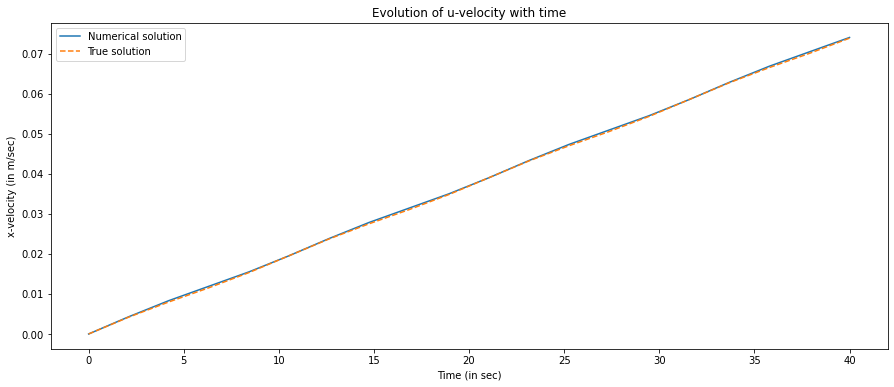

In [6]:
plt.figure(figsize = (15,6))
plt.plot(np.linspace(t_start,t_end,int(t_end/dt)), Um_data[2,2,0:-1], label = 'Numerical solution')
plt.plot(np.linspace(t_start,t_end,int(t_end/dt)), Um_true_data[2,2,0:-1], ls = '--', label = 'True solution')
plt.title('Evolution of u-velocity with time')
plt.xlabel('Time (in sec)')
plt.legend()
plt.ylabel('x-velocity (in m/sec)')

From this analysis, we get $U_m = 0.078$ m/s at $t = 40$ seconds. This matches our analytical test, and so, our numerical solution is correct.

# Test 2: Rotating domain

We have a 2D domain with a constant zonal and zero meridional wind stress. This time, We assume that the Coriolis and forcing terms are both non-zero, i.e., we have a rotating 2D domain with zonal wind stress. We have analytical solutions for the same, and by performing a numerical simulation for two time steps, we hope to match these results with analytical solutions.

The two equations are:

$$\frac{\partial (u_m h_m)}{\partial t} = \frac{\tau_x}{\rho_0} + fv_m h_m,$$
$$\frac{\partial (v_m h_m)}{\partial t} = \frac{\tau_y}{\rho_0} - fu_m h_m.$$

The two equations are:

$$\frac{\partial U_m}{\partial t} = \frac{\tau_x}{\rho_0} + f V_m,$$

$$\frac{\partial V_m}{\partial t} = \frac{\tau_y}{\rho_0} - f U_m.$$

If we were to solve these equations analytically, we would have to dissociate $U_m$ and $V_m$ in the two equations above. We do it as shown below:

$$\frac{\partial^2 U_m}{\partial t^2} = f  (\frac{\tau_y}{\rho_0} - f U_m),$$

$$\frac{\partial^2 V_m}{\partial t^2} =  - f (\frac{\tau_x}{\rho_0} + f V_m).$$

Solving the two equations, we get:

$$ U_m = A sin (ft) + B cos (ft),$$

$$ V_m = C sin (ft) + D cos (ft) - \frac{1}{f} \frac{\tau_x}{\rho_0}, $$

where $A = f(x,y), B = g(x,y), C = h(x,y) \text{ and }D = k(x,y)$. Since $U_m$ and $V_m$ are zero at t $= 0$, $B = C = 0$. 

We consider a wind stress changing in the y-direction as:

$$ \tau_x = 2 sin \Big( \frac{\pi y}{L_y} \Big), $$
so that the wind stress is at its maximum ($ = 2 $ N/m^2) at the middle and zero at the two boundaries. We use the initial conditions that $U_m = V_m = 0$ to obtain the constants A and D:

$$ A = \frac{2}{f \rho_0} sin \Big( \frac{\pi y}{L_y} \Big), $$

$$ D = \frac{2}{f \rho_0} sin \Big( \frac{\pi y}{L_y} \Big). $$

Finally, substituting $A$ and $D$, we get the analytical solution for $U_m$ and $V_m$:

$$ U_m = \frac{2}{f \rho_0} sin \Big (\frac{\pi y}{L_y} \Big) sin(ft), $$

$$ V_m = \frac{2}{f \rho_0} sin\Big (\frac{\pi y}{L_y} \Big) cos (ft) - \frac{2}{f \rho_0} sin \Big ( \frac{\pi y}{L_y} \Big) $$

In [7]:
Lx,Ly = 4100,4000
nx,ny = 52,50
dx,dy = Lx/nx,Ly/ny

g = 9.81
rho0 = 1025
r0 = 6.378*10**6
day = 24*60*60 # length of day [seconds]
omega = 2*np.pi / day
f = 2*omega*np.sin(np.deg2rad(30))

x = np.linspace(0,Lx,nx,dtype = float)
y = np.linspace(0,Ly,ny,dtype = float)
Y,X = np.meshgrid(y,x)

In [8]:
tau_x = 2 * np.sin(np.pi*Y/Ly)
tau_y = np.zeros((nx,ny))

In [9]:
def forcing_Euler(tau):
    f3 = tau/(rho0)
    return f3

def cor_Euler(vel):
    f3 = -f*vel    
    return f3

In [10]:
Um_old = np.zeros((nx,ny))
Um_new = np.zeros((nx,ny))
Vm_old = np.zeros((nx,ny))
Vm_new = np.zeros((nx,ny))

t_start = 0
t_end = 40
dt = 1

Um_true = np.zeros((nx,ny))
Vm_true = np.zeros((nx,ny))

# Needed for animations
Um_data = np.zeros(((nx,ny,int(t_end/dt) + 1)))
Vm_data = np.zeros(((nx,ny,int(t_end/dt) + 1)))
Um_true_data = np.zeros(((nx,ny,int(t_end/dt) + 1)))
Vm_true_data = np.zeros(((nx,ny,int(t_end/dt) + 1)))

for t in np.arange(t_start,t_end,dt):
    Um_new = Um_old + dt*forcing_Euler(tau_x) + dt*cor_Euler(-Vm_old)
    Vm_new = Vm_old + dt*forcing_Euler(tau_y) + dt*cor_Euler(Um_old)
    
    Um_true = 2/(f*rho0) * np.sin(np.pi*Y/Ly) * np.sin(f*t)
    Vm_true = 2/(f*rho0) * np.sin(np.pi*Y/Ly) * np.cos(f*t) - 2/(f*rho0) * np.sin(np.pi*Y/Ly)
    
    Um_data[:,:,int(t/dt)] = Um_old
    Vm_data[:,:,int(t/dt)] = Vm_old
    Um_true_data[:,:,int(t/dt)] = Um_true
    Vm_true_data[:,:,int(t/dt)] = Vm_true
    
    Um_old = Um_new
    Vm_old = Vm_new

In [11]:
fig, ax = plt.subplots(figsize = (10,6))

def update_fig(i):
    
    plt.clf()
    plt.title('Numerical solution for time = ' + str(dt*i) + ' s')
    p1 = plt.contourf(X, Y, Um_data[:,:,i], cmap = 'RdBu', levels = np.linspace(-0.08,0.08,21))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = 40
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/2D_Cor/um_new.mp4',writer = 'ffmpeg',fps = 8)

plt.close(anim._fig)

Video('Videos/2D_Cor/um_new.mp4')

In [12]:
fig, ax = plt.subplots(figsize = (10,6))

def update_fig(i):
    
    plt.clf()
    plt.title('Difference between computed and true solution for time = ' + str(dt*i) + ' s')
    p1 = plt.contourf(X, Y, (Um_data[:,:,i] - Um_true_data[:,:,i]), cmap = 'RdBu', levels = np.linspace(-0.08,0.08,21))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = 40
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/2D_Cor/um_new_error.mp4',writer = 'ffmpeg',fps = 8)

plt.close(anim._fig)

Video('Videos/2D_Cor/um_new_error.mp4')

In [13]:
fig, ax = plt.subplots(figsize = (10,6))

def update_fig(i):
    
    plt.clf()
    plt.title('Numerical solution for time = ' + str(dt*i) + ' s')
    p1 = plt.contourf(X, Y, Vm_data[:,:,i], cmap = 'RdBu', levels = np.linspace(-1.5e-4,1.5e-4,21))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = 40
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/2D_Cor/vm_new.mp4',writer = 'ffmpeg',fps = 8)

plt.close(anim._fig)

Video('Videos/2D_Cor/vm_new.mp4')

In [14]:
fig, ax = plt.subplots(figsize = (10,6))

def update_fig(i):
    
    plt.clf()
    plt.title('Difference between computed and true solution for time = ' + str(dt*i) + ' s')
    p1 = plt.contourf(X, Y, (Vm_data[:,:,i] - Vm_true_data[:,:,i]), cmap = 'RdBu', levels = np.linspace(-1.5e-4,1.5e-4,21))
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    return p1

num_frames = 40
anim = animation.FuncAnimation(fig, update_fig, frames = num_frames, blit = False)
anim.save('Videos/2D_Cor/vm_new_error.mp4',writer = 'ffmpeg',fps = 8)

plt.close(anim._fig)

Video('Videos/2D_Cor/vm_new_error.mp4')